# Spark

This tutorial will show you how to get a Spark instance up and running locally to integrate with JupySQL. You can run this in a Jupyter notebook. We'll use [Spark Connect](https://spark.apache.org/docs/latest/api/python/getting_started/quickstart_connect.html) which is the new thin client for Spark

## Pre-requisites

To run this tutorial, you need to install following Python packages:

In [14]:
%pip install jupysql pyspark==3.4.1 arrow pyarrow==12.0.1 pandas grpcio-status --quiet

Note: you may need to restart the kernel to use updated packages.


## Start Spark instance

We fetch the official image, create a new database, and user (this will take a few seconds).

In [15]:
%%bash
docker run -p 15002:15002 -p 4040:4040 -d --name spark wh1isper/sparglim-server

12f699ee8e8e35ab10186f3c39024a7e443691bb4213e56ca3c2e90cd80daf1b


Our database is running, let's load some data!

## Load sample data

Now, let's fetch some sample data. We'll be using the [NYC taxi dataset](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page):

In [16]:
import pandas as pd
from pyspark.sql.connect.session import SparkSession

spark = SparkSession.builder.remote("sc://localhost").getOrCreate()

df = pd.read_parquet(
    "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-01.parquet"
)
sparkDf = spark.createDataFrame(df.head(10000))

Set [eagerEval](https://spark.apache.org/docs/latest/api/python/getting_started/quickstart_df.html#Viewing-Data) on to print dataframes, This makes Spark print dataframes eagerly in notebook environments, rather than it's default lazy execution which requires .show() to see the data. In Spark 3.4.1 we need to override, as below, but in 3.5.0 it will print in html. 

In [17]:
def __pretty_(self, p, cycle):
    self.show(truncate=False)


from pyspark.sql.connect.dataframe import DataFrame

DataFrame._repr_pretty_ = __pretty_
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

Add dataset to temporary view to allow querying:

In [18]:
sparkDf.createOrReplaceTempView("taxi")

## Query

Now, let's start JupySQL, authenticate, and query the data!

In [19]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [20]:
%sql spark

```{important}
If the cell above fails, you might have some missing packages. Message us on [Slack](https://ploomber.io/community) and we'll help you!
```

List the tables in the database:

In [22]:
%sql show views in default

Running query in 'SparkSession'

namespace,viewName,isTemporary
,taxi,True


We can turn on `lazy_spark` to avoid executing spark plan and return a Spark Dataframe

In [23]:
%config SqlMagic.lazy_execution = True

In [8]:
%sql show views in default

Running query in 'SparkSession'

+---------+--------+-----------+
|namespace|viewName|isTemporary|
+---------+--------+-----------+
|         |taxi    |true       |
+---------+--------+-----------+



In [24]:
%config SqlMagic.lazy_execution = False

List columns in the taxi table:

In [25]:
df = %sql select * from taxi
df.sqlaproxy.dataframe.printSchema()

Running query in 'SparkSession'

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)



Query our data:

In [26]:
%%sql
SELECT COUNT(*) FROM taxi

Running query in 'SparkSession'

count(1)
10000


## Parameterize queries

In [27]:
threshold = 10

In [28]:
%%sql
SELECT COUNT(*) FROM taxi
WHERE trip_distance < {{threshold}}

Running query in 'SparkSession'

count(1)
9476


In [29]:
threshold = 0.5

In [30]:
%%sql
SELECT COUNT(*) FROM taxi
WHERE trip_distance < {{threshold}}

Running query in 'SparkSession'

count(1)
642


## CTEs

In [31]:
%%sql --save many_passengers --no-execute
SELECT *
FROM taxi
WHERE passenger_count > 3
-- remove top 1% outliers for better visualization
AND trip_distance < 18.93

Running query in 'SparkSession'

Skipping execution...

In [32]:
%%sql --save trip_stats --with many_passengers
SELECT MIN(trip_distance), AVG(trip_distance), MAX(trip_distance)
FROM many_passengers

Running query in 'SparkSession'

min(trip_distance),avg(trip_distance),max(trip_distance)
0.0,3.1091381872213963,18.46


This is what JupySQL executes:

In [33]:
query = %sqlcmd snippets trip_stats
print(query)

WITH `many_passengers` AS (
SELECT *
FROM taxi
WHERE passenger_count > 3

AND trip_distance < 18.93)
SELECT MIN(trip_distance), AVG(trip_distance), MAX(trip_distance)
FROM many_passengers


## Profiling

In [34]:
%sqlcmd profile -t taxi

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
count,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,0
unique,2,8766,8745,7,1243,6,2,173,230,4,228,8,3,504,18,3,959,3,0
top,nan,2021-01-01 00:41:19,2021-01-02 00:00:00,nan,nan,nan,N,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,None
freq,nan,4,7,nan,nan,nan,9808,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0
mean,1.6901,nan,nan,1.5080,3.1002,1.0712,nan,158.5551,154.7296,1.3819,11.8822,0.8259,0.4864,1.7846,0.2246,0.2945,16.9696,2.1063,nan
std,0.4625,nan,nan,1.1354,3.5970,1.0755,nan,70.9288,75.2504,0.5552,10.8420,1.1167,0.1041,2.4351,1.2730,0.0570,12.5023,0.9562,nan
min,1,nan,nan,0.0,0.0,1.0,nan,1,1,1,-100.0,-0.5,-0.5,-1.07,-6.12,-0.3,-100.3,-2.5,nan
25%,1.0000,nan,nan,1.0000,1.0400,1.0000,nan,100.0000,83.0000,1.0000,6.0000,0.0000,0.5000,0.0000,0.0000,0.3000,10.3000,2.5000,nan
50%,2.0000,nan,nan,1.0000,1.9300,1.0000,nan,152.0000,151.0000,1.0000,8.5000,0.5000,0.5000,1.5400,0.0000,0.3000,13.5500,2.5000,nan
75%,2.0000,nan,nan,2.0000,3.6000,1.0000,nan,234.0000,234.0000,2.0000,13.5000,2.5000,0.5000,2.6500,0.0000,0.3000,19.3000,2.5000,nan


## Plotting

<Axes: title={'center': "'trip_distance' from 'taxi'"}, xlabel='trip_distance', ylabel='Count'>

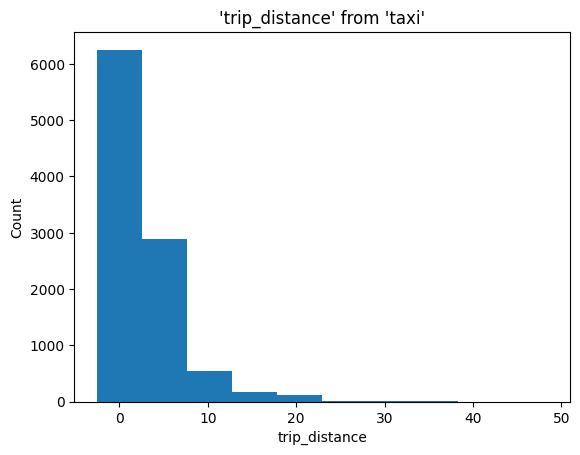

In [35]:
%sqlplot histogram --table taxi --column trip_distance --bins 10

<Axes: title={'center': "'trip_distance' from 'taxi'"}, ylabel='trip_distance'>

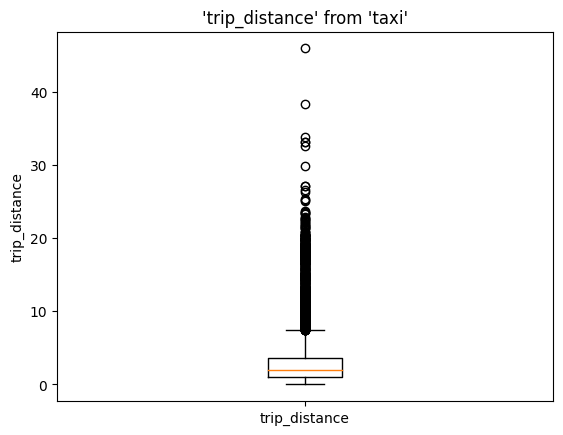

In [36]:
%sqlplot boxplot --table taxi --column trip_distance

Removing NULLs, if there exists any from payment_type

<Axes: title={'center': 'taxi'}, xlabel='payment_type', ylabel='Count'>

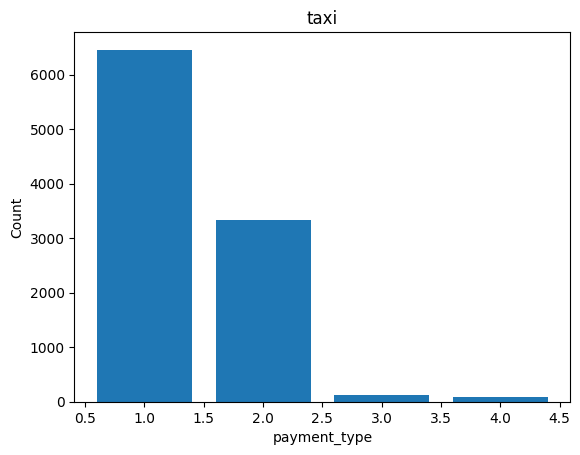

In [37]:
%sqlplot bar --table taxi --column payment_type

Removing NULLs, if there exists any from payment_type

<Axes: title={'center': 'taxi'}>

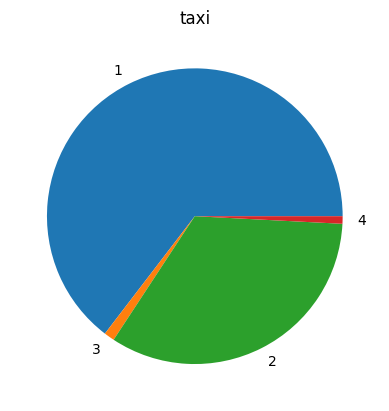

In [38]:
%sqlplot pie --table taxi --column payment_type

In [39]:
from sql.ggplot import ggplot, aes, geom_histogram

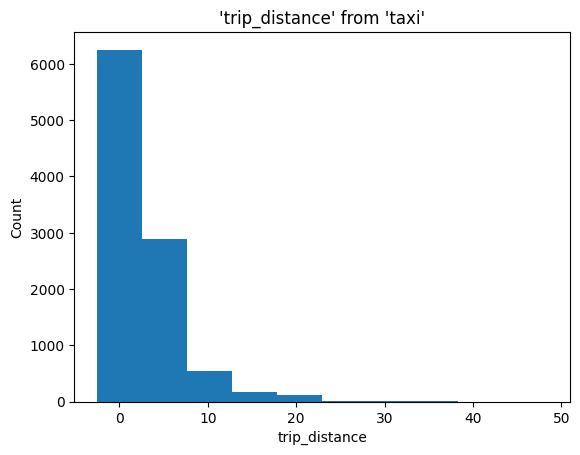

In [40]:
(ggplot(table="taxi", mapping=aes(x="trip_distance")) + geom_histogram(bins=10))

## Clean up

To stop and remove the container:

In [41]:
! docker container ls

CONTAINER ID   IMAGE                                                      COMMAND                  CREATED              STATUS              PORTS                                              NAMES
12f699ee8e8e   wh1isper/sparglim-server                                   "tini -- sparglim-se…"   About a minute ago   Up About a minute   0.0.0.0:4040->4040/tcp, 0.0.0.0:15002->15002/tcp   spark
f019407c6426   docker.dev.slicelife.com/onelogin-aws-assume-role:stable   "onelogin-aws-assume…"   2 weeks ago          Up 2 weeks                                                             heuristic_tu


In [42]:
%%capture out
! docker container ls --filter ancestor=wh1isper/sparglim-server --quiet

In [43]:
container_id = out.stdout.strip()
print(f"Container id: {container_id}")

Container id: 12f699ee8e8e


In [44]:
! docker container stop {container_id}

12f699ee8e8e


In [45]:
! docker container rm {container_id}

12f699ee8e8e
